In [2]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
# from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [3]:
# tỉ lệ 7:3
df = pd.read_csv('NVL Historical Data 1_6.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df['Price'].str.replace(',', '')
# Chuyển sang dạng số
df = pd.to_numeric(df)
df = df[::-1]

df = df.reset_index(drop=True) # Reset the index

In [4]:
scaler = StandardScaler()
df1 = scaler.fit_transform(np.array(df).reshape(-1, 1))

In [5]:
# Assuming df is your DataFrame containing your data
train_size = int(0.7 * len(df))

# Split the data into training and testing sets
train_data = df1[:train_size]
test_data = df1[train_size:]

In [6]:
train_data
test_data.shape

(480, 1)

In [7]:
# !pip install tbats

In [8]:
from tbats import BATS, TBATS
# 3. Quá trình Training
y_train = np.array(train_data)
# Thử các giá trị của seasonal_periods => Nhận thấy data không có tính mùa vụ rõ ràng => đều ra kết quả đường thẳng
estimator = TBATS(
    use_arma_errors=True,
    use_box_cox=True,
    use_trend=True
)
model = estimator.fit(y_train)

aic_value = model.aic
print(aic_value)

563.9565284687967


In [9]:
# 4. Quá trình testing
y_test = np.array(test_data)

In [10]:
# 90 days
y_pred_90 = model.forecast(steps=570)
y_next_90_days = y_pred_90[-90:]
y_pred = y_pred_90[:480]

In [11]:
train_data = df[:train_size]
test_data = df[train_size:]
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_next_90_days = scaler.inverse_transform(y_next_90_days.reshape(-1, 1))

In [12]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)


MAE: 47834.06839814067
RMSE: 52333.63781140252
MAPE: 3.070156983447849


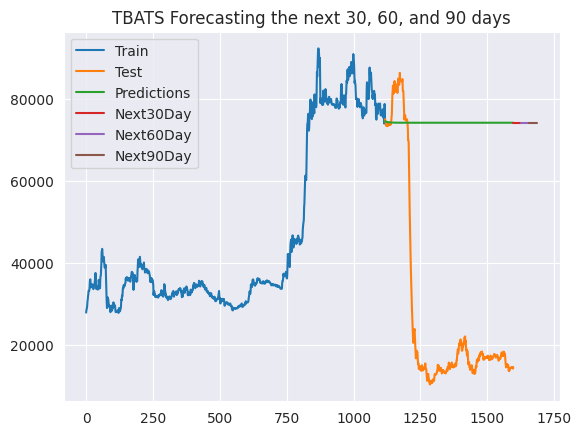

In [13]:
last_index = df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data_1 = pd.RangeIndex(start=last_index+29, stop=last_index+60, step=1)
last_data_2 = pd.RangeIndex(start=last_index+59, stop=last_index+90, step=1)

plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_90_days[0:30])
plt.plot(last_data_1,y_next_90_days[29:60])
plt.plot(last_data_2,y_next_90_days[59:90])
plt.title('TBATS Forecasting the next 30, 60, and 90 days')
plt.legend(['Train', 'Test', 'Predictions','Next30Day','Next60Day','Next90Day'])
plt.show()